In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
a = (2251262626%7+1)
a

5

In [41]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt


In [42]:
train = pd.read_csv(r"/content/drive/MyDrive/Hoc_hanh/Time_Series/train.csv")


In [43]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [44]:
train_series = train.loc[train["Publication_Day"] == "Friday"]

In [45]:
train_series.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
31,31,Global News,Episode 92,118.15,News,86.22,Friday,Morning,64.88,2.0,Neutral,57.48380
34,34,Study Sessions,Episode 30,8.66,Education,49.75,Friday,Morning,NaN,3.0,Neutral,6.67525
35,35,Sport Spot,Episode 63,75.02,Sports,95.89,Friday,Night,59.71,0.0,Positive,40.33025
58,58,Sports Central,Episode 33,31.90,Sports,63.61,Friday,Evening,64.38,1.0,Negative,19.28000
83,83,Sports Central,Episode 80,25.34,Sports,53.30,Friday,Evening,NaN,3.0,Positive,23.71495


In [46]:
observations = train_series['Listening_Time_minutes'].values

# ***Kalman Filter***

In [47]:
n = len(observations)
x_est_1 = np.zeros(n)
P = np.zeros(n)
Q = 0.01
R = 10
x_est_1[0] = observations[0]
P[0] = 1

for t in range(1, n):
    x_pred = x_est_1[t-1]
    P_pred = P[t-1] + Q

    K = P_pred / (P_pred + R)
    x_est_1[t] = x_pred + K * (observations[t] - x_pred)
    P[t] = (1 - K) * P_pred

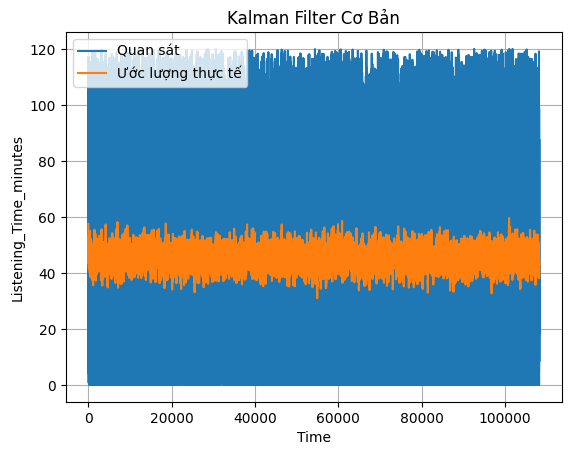

In [48]:
plt.plot(observations, label='Quan sát')
plt.plot(x_est_1, label='Ước lượng thực tế')
plt.title('Kalman Filter Cơ Bản')
plt.xlabel('Time')
plt.ylabel('Listening_Time_minutes')
plt.legend()
plt.grid(True)
plt.show()

# **Extended Kalman Filter (EKF)**

In [49]:
n = len(observations)
x_est_2 = np.zeros(n)
P = np.zeros(n)
Q = 0.1
R = 1.0

def f(x):
  return np.sqrt(x + 1)
def h(x):
  return x**2
def df_dx(x):
  return 0.5 / np.sqrt(x + 1)
def dh_dx(x):
  return 2 * x

x_est_2[0] = np.sqrt(observations[0])
P[0] = 1.0

for k in range(1, n):

    x_pred = f(x_est_2[k - 1])
    F = df_dx(x_est_2[k - 1])
    P_pred = F * P[k - 1] * F + Q

    H = dh_dx(x_pred)
    z_pred = h(x_pred)
    y = observations[k] - z_pred
    S = H * P_pred * H + R
    K = P_pred * H / S

    x_est_2[k] = x_pred + K * y
    P[k] = (1 - K * H) * P_pred

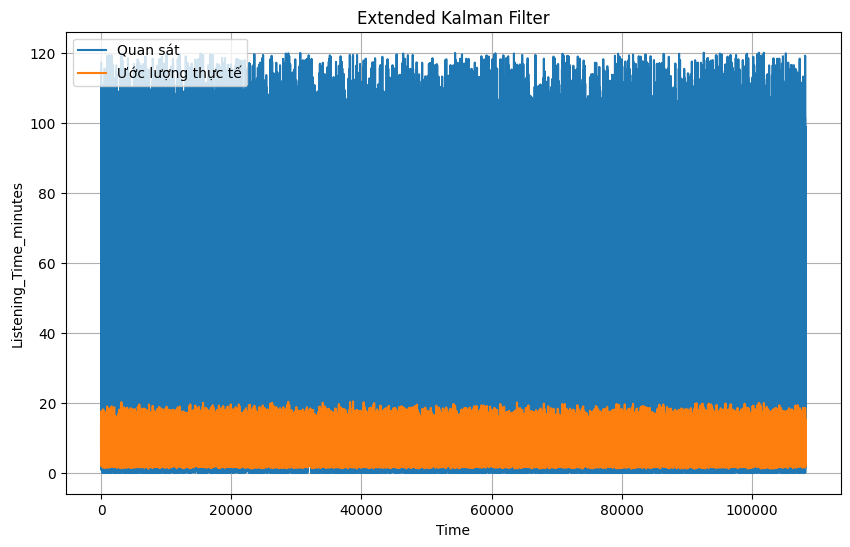

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(n), observations, label='Quan sát')
plt.plot(range(n), x_est_2, label='Ước lượng thực tế')
plt.xlabel('Time')
plt.ylabel('Listening_Time_minutes')
plt.title('Extended Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()

# **Unscented Kalman Filter (UKF)**

In [51]:
n = len(observations)
x_est_3 = np.zeros(n)
P = np.zeros(n)


Q = 0.1
R = 1.0
alpha = 1e-3
kappa = 0
beta = 2
L = 1
lambda_ = alpha**2 * (L + kappa) - L
gamma = np.sqrt(L + lambda_)


Wm = np.full(2 * L + 1, 1 / (2 * (L + lambda_)))
Wc = np.full(2 * L + 1, 1 / (2 * (L + lambda_)))
Wm[0] = lambda_ / (L + lambda_)
Wc[0] = lambda_ / (L + lambda_) + (1 - alpha**2 + beta)


x_est_3[0] = np.sqrt(observations[0])
P[0] = 1.0

for k in range(1, n):
    # Tạo điểm sigma
    sqrt_P = np.sqrt((L + lambda_) * P[k - 1])
    sigma_pts = np.array([x_est_3[k - 1], x_est_3[k - 1] + sqrt_P, x_est_3[k - 1] - sqrt_P])

    # Dự đoán
    sigma_f = f(sigma_pts)
    x_pred = np.sum(Wm * sigma_f)
    P_pred = np.sum(Wc * (sigma_f - x_pred)**2) + Q

    # Cập nhật
    sigma_h = h(sigma_f)
    z_pred = np.sum(Wm * sigma_h)
    P_zz = np.sum(Wc * (sigma_h - z_pred)**2) + R
    P_xz = np.sum(Wc * (sigma_f - x_pred) * (sigma_h - z_pred))
    K = P_xz / P_zz

    x_est_3[k] = x_pred + K * (observations[k] - z_pred)
    P[k] = P_pred - K * P_zz * K

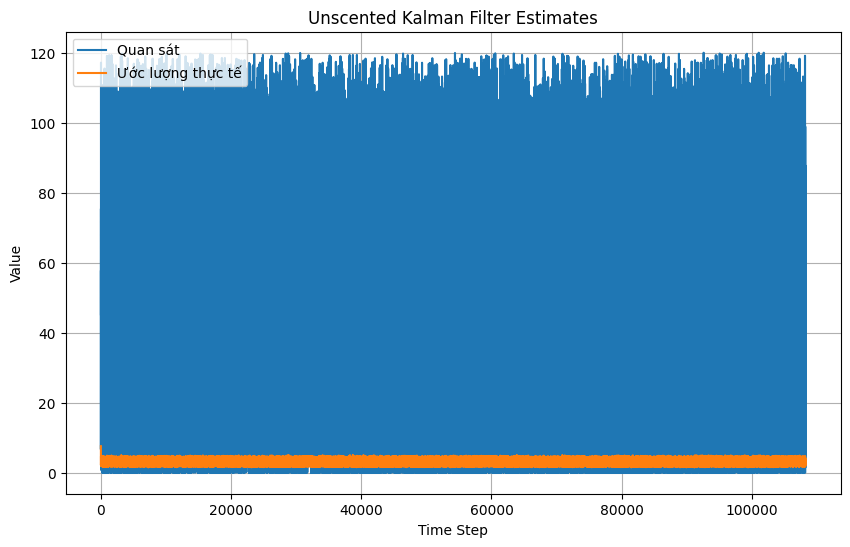

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(range(n), observations, label='Quan sát')
plt.plot(range(n), x_est_3, label='Ước lượng thực tế')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Unscented Kalman Filter Estimates')
plt.legend()
plt.grid(True)
plt.show()